In [1]:
import pandas as pd
import numpy as np
import gzip
from collections import defaultdict
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer,text_to_word_sequence

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
vocab_size = 400000
embedding_size = 50
maxlen = 10
# embeddings_path = 'glove.6B.50d.txt.gz'

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split # from sklearn.cross_validation import train_test_split

df = pd.read_csv('Data/Consumer_Complaints.csv', encoding='latin-1')
df = df[pd.notnull(df['Consumer complaint narrative'])]
train, test  = train_test_split( df, test_size=0.20, random_state=10)

/Applications/anaconda3/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
train.shape

(307325, 18)

In [9]:
test.shape

(76832, 18)

In [10]:
train.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
726160,05/04/2016,Credit reporting,NaN,Incorrect information on credit report,Reinserted previously deleted info,I have XXXX medical bills on transunion and XX...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",FL,NaN,NaN,Consent provided,Web,05/06/2016,Closed with non-monetary relief,Yes,No,1910019
922801,03/19/2015,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,I was studying in the XXXX last year and opene...,Company chooses not to provide a public response,U.S. BANCORP,NaN,NaN,NaN,Consent provided,Web,03/23/2015,Closed with explanation,Yes,No,1291306
593993,01/06/2017,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,"Credit history request- never authorized, comp...",Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MN,554XX,NaN,Consent provided,Web,02/27/2017,Closed with explanation,Yes,Yes,2276154
438900,09/03/2017,Credit card or prepaid card,Store credit card,Getting a credit card,Card opened as result of identity theft or fraud,"Today on X/XX/17, I went to the XXXX XXXX XXXX...",NaN,Alliance Data Card Services,CA,940XX,NaN,Consent provided,Web,09/07/2017,Closed with non-monetary relief,Yes,NaN,2657667
308042,03/01/2018,Credit card or prepaid card,General-purpose credit card or charge card,Fees or interest,Problem with fees,I put {$10000.00} into a secured credit card w...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,FL,NaN,NaN,Consent provided,Web,03/01/2018,Closed with monetary relief,Yes,NaN,2830051


In [39]:
# Common methods to read data and get embeddings
def read_data():
    df_train = train
    df_val = test
    categories = list(set(df_train.Product.values))
    return df_train, df_val, categories

def load_embeddings():
    word_index = {}
    embeddings = np.zeros((vocab_size,embedding_size))
    glove_data = r'C:\Users\Rothschild\Downloads\glove.6B.50d.txt'
    file = open(glove_data, encoding="utf8")
    for i, line in enumerate(file):
        line_tokens = line.split()
        word = line_tokens[0]
        embeddings[i] = np.asarray(line_tokens[1:],dtype='float32')
        word_index[word] = i
    return embeddings,word_index

In [32]:
def get_embedding(word,word_index,embeddings):
    if word in word_index:
        return embeddings[word_index[word]].reshape(((embedding_size,1)))
    else:
        return np.zeros((embedding_size,1))

In [33]:
# Methods for Neural Network Model
def prepare_data(df_train,df_val,categories):
    train_text = df_train['Consumer complaint narrative'].tolist()
    val_text = df_val['Consumer complaint narrative'].tolist()
    tk = Tokenizer(num_words = vocab_size, lower = True)
    tk.fit_on_texts(train_text + val_text)
    x_train = pad_sequences(tk.texts_to_sequences(train_text),maxlen=maxlen)
    x_val = pad_sequences(tk.texts_to_sequences(val_text),maxlen=maxlen)
    y_train = category_to_one_hot(df_train['Product'].values,categories)
    y_val = category_to_one_hot(df_val['Product'].values,categories) 
    return tk.word_index,x_train,y_train,x_val,y_val

def prepare_data_from_full_word_index(df_train,df_val,categories,word_index):
    train_text = df_train['Consumer complaint narrative'].tolist()
    val_text = df_val['Consumer complaint narrative'].tolist()
    x_train = get_pad_sequences(train_text,word_index)
    x_val = get_pad_sequences(val_text,word_index)
    y_train = category_to_one_hot(df_train['Product'].values,categories)
    y_val = category_to_one_hot(df_val['Product'].values,categories) 
    return word_index,x_train,y_train,x_val,y_val

def get_pad_sequences(text_list,word_index):
    seqs = []
    for text in text_list:
        word_seq = text_to_word_sequence(text.lower())
        seq = []
        for word in word_seq:
          if word in word_index:
            seq.append(word_index[word])
        seqs.append(seq)
    return pad_sequences(seqs,maxlen)


# Convert the list of categories to one_hot vector
def category_to_one_hot(cat_list,cat_master):
    cat_dict = {}
    for i,cat in enumerate(cat_master):
        cat_dict[cat] = i
    cat_integers = [cat_dict[cat] for cat in cat_list]
    return to_categorical(cat_integers,num_classes=len(cat_master))

# Convert one_hot to category
def one_hot_to_category(cat_one_hot_list,cat_master):
    return [cat_master[cat_one_hot.argmax()] for cat_one_hot in cat_one_hot_list]

# Get the embedding weights for the model
def get_embedding_matrix_for_model(embeddings,word_index):
    train_val_words = min(vocab_size, len(word_index)) +1
    embedding_matrix = np.zeros((train_val_words, embedding_size))
    for word, i in word_index.items():
        embedding_vector = get_embedding(word,word_index,embeddings).flatten()
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Build the keras model
def build_model(embedding_matrix,categories):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_size, weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model.add(LSTM(32))
#   We don't lose much by replacing LSTM with this flatten layer (as we have short sequences)
#   model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(categories), activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
    return model

def get_val(numerator,divisor):
    return float('nan') if divisor == 0 else np.round(numerator/divisor,3)

def analyze_predictions(categories,y_true,y_pred):
    tp = defaultdict(int)
    tn = defaultdict(int)
    fp = defaultdict(int)
    fn = defaultdict(int)
    precisions = []
    recalls = []
    f1s = []
    cat_counts = defaultdict(int)
    for cat in y_true:
        cat_counts[cat]+=1 
    correct = 0
    conf_mat = defaultdict(dict)
    for cat1 in categories:
        for cat2 in categories:
            conf_mat[cat1][cat2] = 0
    for y,y_hat in zip(y_true,y_pred):
        conf_mat[y][y_hat]+=1
        if y == y_hat:
            correct+=1
            tp[y]+=1
        else:
            fp[y_hat]+=1
            fn[y]+=1
    print('Overall Accuracy:',round(correct/len(y_pred),3))
    for cat in categories:
        precision = get_val(tp[cat],tp[cat]+fp[cat])
        recall = get_val(tp[cat],(tp[cat]+fn[cat]))
        f1 = get_val(2*precision*recall,precision + recall)
        precisions.append(precision)
        recalls.append(recall)  
        f1s.append(f1)
        print('{} --> Precision:{},Recall:{},F1:{}'.format(cat,precision,recall,f1))
    print ('\nAverages---> Precision:{}, Recall:{}, F1:{}'.format(np.round(np.nanmean(precisions),3),                                                                                                np.round(np.nanmean(recalls),3),
                                                               np.round(np.nanmean(f1s),3))
          )
          
    print('\nConfusion Matrix')
    for cat1 in categories:
        print('\n'  +cat1+'({}) --> '.format(cat_counts[cat1]),end='')
        for cat2 in categories:
            print('{}({})'.format(cat2,conf_mat[cat1][cat2]),end=' , ')
    print('')
    


# From Deep Learning with Python book
def make_history_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', color='green',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', color='green',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [34]:
import numpy as np
np.random.seed(42) # for reproducibility
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
df_train,df_val,categories = read_data()

In [40]:
# Load Glove 50-d embeddings
embeddings,word_index = load_embeddings()

In [41]:
# Prepare the data for the model
tk_word_index,x_train,y_train,x_val,y_val = prepare_data_from_full_word_index(df_train,df_val,categories,word_index)

In [42]:
# Get the embedding matrix for the model, build model, display model summary
embedding_matrix = get_embedding_matrix_for_model(embeddings,word_index)
model = build_model(embedding_matrix,categories)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 18)                594       
Total params: 20,012,324
Trainable params: 12,274
Non-trainable params: 20,000,050
_________________________________________________________________


In [43]:
# Train the model, record history
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=24,
                    shuffle=False,
                    validation_data=(x_val, y_val))

Train on 307325 samples, validate on 76832 samples
Epoch 1/5
307325/307325 [==============================] - 109s 356us/step - loss: 1.9574 - acc: 0.3618 - val_loss: 1.8896 - val_acc: 0.3902
Epoch 2/5
307325/307325 [==============================] - 102s 331us/step - loss: 1.8670 - acc: 0.3955 - val_loss: 1.8724 - val_acc: 0.3987
Epoch 3/5
307325/307325 [==============================] - 96s 313us/step - loss: 1.8544 - acc: 0.4006 - val_loss: 1.8682 - val_acc: 0.4002
Epoch 4/5
307325/307325 [==============================] - 96s 312us/step - loss: 1.8525 - acc: 0.4033 - val_loss: 1.8680 - val_acc: 0.4006
Epoch 5/5
307325/307325 [==============================] - 103s 336us/step - loss: 1.8529 - acc: 0.4043 - val_loss: 1.8736 - val_acc: 0.3998


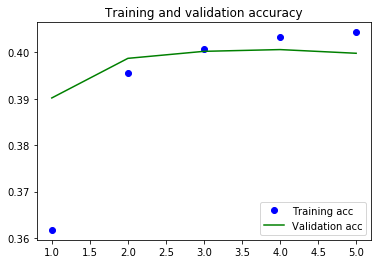

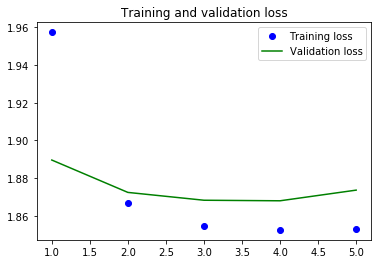

In [44]:
make_history_plot(history)

In [45]:
# Make and analyze training predictions
train_predictions = one_hot_to_category(model.predict(x_train),categories)
analyze_predictions(categories,df_train['Product'].values,train_predictions)

Overall Accuracy: 0.406
Consumer Loan --> Precision:0.31,Recall:0.064,F1:0.106
Money transfer, virtual currency, or money service --> Precision:nan,Recall:0.0,F1:nan
Credit card --> Precision:0.353,Recall:0.001,F1:0.002
Virtual currency --> Precision:nan,Recall:0.0,F1:nan
Credit reporting, credit repair services, or other personal consumer reports --> Precision:0.411,Recall:0.734,F1:0.527
Credit reporting --> Precision:0.675,Recall:0.02,F1:0.039
Other financial service --> Precision:nan,Recall:0.0,F1:nan
Mortgage --> Precision:0.363,Recall:0.542,F1:0.435
Bank account or service --> Precision:0.296,Recall:0.061,F1:0.101
Debt collection --> Precision:0.452,Recall:0.549,F1:0.496
Student loan --> Precision:0.458,Recall:0.213,F1:0.291
Money transfers --> Precision:nan,Recall:0.0,F1:nan
Checking or savings account --> Precision:0.231,Recall:0.107,F1:0.146
Payday loan --> Precision:nan,Recall:0.0,F1:nan
Credit card or prepaid card --> Precision:0.292,Recall:0.16,F1:0.207
Payday loan, title lo

In [46]:
# Make and analyze validation predictions
val_predictions = one_hot_to_category(model.predict(x_val),categories)
analyze_predictions(categories,df_val['Product'].values,val_predictions)

Overall Accuracy: 0.4
Consumer Loan --> Precision:0.295,Recall:0.061,F1:0.101
Money transfer, virtual currency, or money service --> Precision:nan,Recall:0.0,F1:nan
Credit card --> Precision:0.364,Recall:0.001,F1:0.002
Virtual currency --> Precision:nan,Recall:0.0,F1:nan
Credit reporting, credit repair services, or other personal consumer reports --> Precision:0.413,Recall:0.724,F1:0.526
Credit reporting --> Precision:0.637,Recall:0.02,F1:0.039
Other financial service --> Precision:nan,Recall:0.0,F1:nan
Mortgage --> Precision:0.35,Recall:0.532,F1:0.422
Bank account or service --> Precision:0.271,Recall:0.058,F1:0.096
Debt collection --> Precision:0.437,Recall:0.54,F1:0.483
Student loan --> Precision:0.469,Recall:0.218,F1:0.298
Money transfers --> Precision:nan,Recall:0.0,F1:nan
Checking or savings account --> Precision:0.217,Recall:0.1,F1:0.137
Payday loan --> Precision:nan,Recall:0.0,F1:nan
Credit card or prepaid card --> Precision:0.281,Recall:0.148,F1:0.194
Payday loan, title loan, 